## Imports

In [1]:
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import mysql.connector
from mysql.connector import errorcode
import time
import json
import csv
import re
import pandas as pd
from spellchecker import SpellChecker
from textblob import Word
import string
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objects as go
import matplotlib
from collections import Counter
from autocorrect import Speller
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
from profanity_check import predict, predict_prob

/usr/local/lib/python3.8/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:313: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.20.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.svm.classes module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.svm. Anything that cannot be importe

## Setting up MYSQL and Notebook
#### The following code was used to create a connection between this notebook and a (local) database

In [2]:
config = {
        'user': 'root',
        'password': 'root',
        'host': 'mysql-db',
        'port': '3306',
        'database': 'tweet_analysis'}
con = mysql.connector.connect(**config)
cursor = con.cursor(buffered=True)

## Consumer and Access Tokens/Secrets
#### These were used to access the Twitter API in order to stream tweets 


In [3]:
ckey="YOUR_CONSUMER_KEY"                               
csecret="YOUR_CONSUMER_SECRET"   
atoken="YOUR_ACCESS_TOKEN"   
asecret="YOUR_ACCESS_SECRET"      

## Values chosen to search for in tweets
#### When streaming, the values listed below were used to extract relevant tweets. 

In [4]:
val = ["coronavirus","corona-virus", "corona virus", "covid19", "covid 19", "covid"] 

##### function to remove html tags when streaming to database

In [5]:
def remove_html_tags(text):
    """Remove html tags from a string"""
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

## Listener class 
#### Setup for streaming/filtering tweets and extracting to unstructured and structured database 

In [6]:
class listener(StreamListener):

    def on_data(self, data):
        all_data = json.loads(data)
        # check to ensure there is text in 
        # the json data
        if 'text' in all_data:
          tweet = all_data["text"]
          tweet_id = all_data["id_str"]
          username = all_data["user"]["screen_name"]
          hashtags = all_data['entities']['hashtags']
          source = remove_html_tags(all_data["source"]) 
          created_at = all_data['created_at'].split()
          day = created_at[0]
          month = created_at[2] + " " + created_at[1]
          year = created_at[5]
          time = created_at[3]
        
          hashes = list()
          for hashtag in hashtags:
            text = hashtag['text'].lower()
            hashes.append(text)
            
          for x in hashes:
            if x in val:
              writer.writerow(all_data.values())
              cursor.execute(
                "INSERT INTO tweetinfo (tweet_id, username, tweet, hashtag, source, day, month, year, time) VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s)",
                (tweet_id, username, tweet, str(hashes), source, day, month, year, time))
          
              con.commit()
          
              print((username,tweet))
          
          return True
        else:
          return True

    def on_error(self, status):
        print(status)



## Implementation of streaming tweets
#### NB: Interrupt kernel to stop tweet streaming!

In [7]:
with open("tweet_info_1.csv", 'w', encoding="utf-8") as file:
  global writer
  writer = csv.writer(file)
  
  writer.writerow(['created_at', 'id', 'id_str', 'text', 'source', 'truncated', 'in_reply_to_status_id',
  'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name',
  'user', 'geo', 'coordinates', 'place', 'contributors', 'retweeted_status', 'quoted_status_id', 
  'quoted_status_id_str', 'quoted_status', 'quoted_status_permalink', 'is_quote_status', 'quote_count', 
  'reply_count', 'retweet_count', 'favorite_count', 'entities', 'favorited', 'retweeted', 'possibly_sensitive',
  'filter_level', 'lang', 'timestamp_ms'])
    
  auth = OAuthHandler(ckey, csecret)
  auth.set_access_token(atoken, asecret)
    

  twitterStream = Stream(auth, listener())
  twitterStream.filter(track=val,
  languages = ["en"], stall_warnings = True)

('giamcanpowerife', 'The latest The Weight loss Daily! https://t.co/LUMsyBm6lS #coronavirus #cambridgetechnicals')
('ToddFryer4', 'RT @TomFitton: There is no "science" behind masks working to contain #Coronavirus. It is as if our pubic health discussions on this topic a…')
('tutusaysso', 'RT @ZMPublicHealth: Daily #COVID19 update: in the last 24hrs, Zambia recorded 472 new cases,12 recoveries and 3 additional community deaths…')
('kelly75771', "RT @TomFitton: Chief Justice Roberts seems to be playing politics again. He doesn't want the Supreme Court to restrict #Coronavirus shutdow…")
('560Nootan', "RT @Arzz28: When a minister or CM gets affected by #COVID19 why do they get admitted in best private hospitals with best amenities? Don't y…")
('featherduster', 'RT @creativecatjk: I know people are upset that Marise Payne is going to America because of #covid risks, but could we please start getting…')
('VioletW98218954', 'RT @MaryamHenein: #CDC #Covid19 DATA CORRUPTION?\n\n"While I cannot

('Hrithik03781294', 'RT @NH_India: During these difficult times of #lockdown and #COVID19 pandemic, #Bollywood actor #HrithikRoshan has come to the #dancers’ re…')
('Freediver_Doris', 'RT @YourAnonNews: Yesterday, there were 289,028 new cases of #COVID19 \n\n6,199 deaths were reported in the past 24 hours.\n\nThis brings the t…')
('leo_bergonzi', 'RT @wef: Here are 5 ways beaches will be different this summer https://t.co/vYD9RKkJ6A #coronavirus #beaches https://t.co/1SfoKlsmdS')
('SendCakeFilms', 'Help slow the spread of #COVID19 and identify at risk cases sooner by self-reporting your symptoms daily, even if y… https://t.co/oVst2N9FoJ')
('tjkgolf21', 'RT @TomFitton: There is no "science" behind masks working to contain #Coronavirus. It is as if our pubic health discussions on this topic a…')
('DeepakR75647253', 'RT @ANI: Chief Minister Uddhav Thackeray today inaugurated a #COVID19 Care Center and a testing lab in Dombivli, via video conference: Maha…')
('VenusGupta9', 'RT @ashish_nyc

('Veersin21986572', 'RT @capt_amarinder: I appeal to the Heads of religious institutions to ensure enforcement of social distancing &amp; other #Covid19 precautions…')
('Physologius', 'RT @DrTedros: As long as #COVID19 is circulating, we are all at risk. That’s why we’re asking everyone to treat the decisions about where t…')
('mohancnath', 'RT @IPR_Odisha: Live Press briefing #Covid19 https://t.co/MB9yPD2Cyf')
('sallytyro', 'RT @petertimmins3: Europe is showing signs of a second wave of #coronavirus.\n\nUK is about 3 weeks behind. No doubt the UK government will b…')
('DonnyJ43065901', 'RT @TomFitton: There is no "science" behind masks working to contain #Coronavirus. It is as if our pubic health discussions on this topic a…')
('mapsgal', 'RT @mommamia1217: People amaze me.\n\nThis yr we couldn’t landscape our yard BC of the $$$ burden that #Covid brought. This was a source of a…')
('jaime_trick', 'RT @CPHO_Canada: 1/3 Younger age groups are not invincible against #COVID19; in fact, o

('HeatherMassey2', 'RT @SimonFraser00: Might the Prime Minister have understood more about #coronavirus sooner if he had chaired those early cabinet office bri…')
('Markll_revive', 'RT @chrischirp: THREAD: Key points from my overview of latest #COVID19 numbers in the weekly @IndependentSage briefing. Firstly, for the fi…')
('RegioCZ_SK', 'RT @RegioEvaluation: The #covid19 #cohesionpolicy indicators paper and webinar recordings are public here under "implementing" : https://t.…')
('PolicialCrazies', 'Top 10 causes of death in U.S. (annual average) vs #COVID19 (so far)\n\nHeart disease: 647K\nCancer: 599K\nAccidents: 1… https://t.co/6kkofKG6wt')
('YellowLightCrtv', 'RT @Craig_A_Spencer: Hi @FoxNews,\n\nYour producers keep booking me and ‘confirming’ me to discuss #COVID19, then cancelling an hour or two b…')
('biobyber', 'Have been busy. Speeded up my rate of work and finished the enzyme playlist.  Am Continuing #covid19 project. Hopin… https://t.co/5hHQY1ORXX')
('angela_mcshane', 'RT @A

KeyboardInterrupt: 

## Unstructured database
#### A look at what the unstructured database looks like (converted csv into dataframe)

In [8]:
df_unstructured = pd.read_csv("tweet_info_1.csv", error_bad_lines=False)
df_unstructured.head()

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,reply_count,retweet_count,favorite_count,entities,favorited,retweeted,possibly_sensitive,filter_level,lang,timestamp_ms
0,Sat Jul 25 11:10:31 +0000 2020,1286982153650282497,1286982153650282497,The latest The Weight loss Daily! https://t.co...,"<a href=""https://paper.li"" rel=""nofollow"">Pape...",False,NaN,NaN,NaN,NaN,...,False,False,low,en,1595675431059,NaN,NaN,NaN,NaN,NaN
1,Sat Jul 25 11:10:31 +0000 2020,1286982154514313217,1286982154514313217,"RT @TomFitton: There is no ""science"" behind ma...","<a href=""http://twitter.com/download/android"" ...",False,NaN,NaN,NaN,NaN,...,0,0,0,"{'hashtags': [{'text': 'Coronavirus', 'indices...",False,False,low,en,1.595675e+12,NaN
2,Sat Jul 25 11:10:32 +0000 2020,1286982159291617281,1286982159291617281,RT @ZMPublicHealth: Daily #COVID19 update: in ...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,NaN,NaN,NaN,...,False,False,low,en,1595675432404,NaN,NaN,NaN,NaN,NaN
3,Sat Jul 25 11:10:32 +0000 2020,1286982159895597062,1286982159895597062,RT @TomFitton: Chief Justice Roberts seems to ...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,NaN,NaN,NaN,...,False,False,low,en,1595675432548,NaN,NaN,NaN,NaN,NaN
4,Sat Jul 25 11:10:32 +0000 2020,1286982160876883969,1286982160876883969,RT @Arzz28: When a minister or CM gets affecte...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,NaN,NaN,NaN,...,0,0,0,"{'hashtags': [{'text': 'COVID19', 'indices': [...",False,False,low,en,1.595675e+12,NaN


In [9]:
df_unstructured.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   created_at                 209 non-null    object 
 1   id                         209 non-null    int64  
 2   id_str                     209 non-null    int64  
 3   text                       209 non-null    object 
 4   source                     208 non-null    object 
 5   truncated                  209 non-null    object 
 6   in_reply_to_status_id      12 non-null     object 
 7   in_reply_to_status_id_str  2 non-null      float64
 8   in_reply_to_user_id        4 non-null      float64
 9   in_reply_to_user_id_str    4 non-null      float64
 10  in_reply_to_screen_name    4 non-null      object 
 11  user                       199 non-null    object 
 12  geo                        12 non-null     object 
 13  coordinates                0 non-null      float64

## Structured database
#### A look at the structured database (exported table from MySQL to CSV -> converted to dataframe)

In [10]:
QUERY='SELECT * FROM tweet_analysis.tweetinfo;'

cursor.execute(QUERY)
result=cursor.fetchall()

with open("tweet_info_2.csv", 'w', encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(['tweet_id','username','tweet','hashtag','source','day','month','year','time'])
    for x in result:
        writer.writerow(x)

In [11]:
df_structured = pd.read_csv("tweet_info_2.csv")
df_structured.head()

,tweet_id,username,tweet,hashtag,source,day,month,year,time
0,1286982153650282497,giamcanpowerife,The latest The Weight loss Daily! https://t.co...,"['coronavirus', 'cambridgetechnicals']",Paper.li,Sat,25 Jul,2020,11:10:31
1,1286982154514313217,ToddFryer4,"RT @TomFitton: There is no ""science"" behind ma...",['coronavirus'],Twitter for Android,Sat,25 Jul,2020,11:10:31
2,1286982159291617281,tutusaysso,RT @ZMPublicHealth: Daily #COVID19 update: in ...,['covid19'],Twitter for Android,Sat,25 Jul,2020,11:10:32
3,1286982159895597062,kelly75771,RT @TomFitton: Chief Justice Roberts seems to ...,['coronavirus'],Twitter for iPhone,Sat,25 Jul,2020,11:10:32
4,1286982160876883969,560Nootan,RT @Arzz28: When a minister or CM gets affecte...,['covid19'],Twitter for Android,Sat,25 Jul,2020,11:10:32


In [12]:
df_structured.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  209 non-null    int64 
 1   username  209 non-null    object
 2   tweet     209 non-null    object
 3   hashtag   209 non-null    object
 4   source    208 non-null    object
 5   day       209 non-null    object
 6   month     209 non-null    object
 7   year      209 non-null    int64 
 8   time      209 non-null    object
dtypes: int64(2), object(7)
memory usage: 14.8+ KB


## Visualizing the data

### Visualizing most used hashtags 

In [13]:
hash_dict = {}

In [14]:
def transform_hashes(x):
    s = ''
    for i in x:
        if i not in string.punctuation:
            s = s + i
    return s.split()

In [15]:
for i in range(len(df_structured['hashtag'])):
    j = transform_hashes(df_structured['hashtag'][i])
    for k in j:
        if k not in hash_dict:
            hash_dict[k] = 1
        else:
            current_val = hash_dict[k]
            hash_dict[k] = current_val + 1
hashes_df = pd.DataFrame.from_dict(hash_dict, orient='index').reset_index()
hashes_df.columns = ['Hashtag', 'Number of Hashtags']
#hashes_df.info()

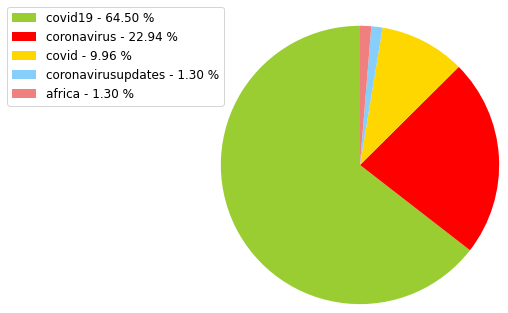

In [16]:
import numpy as np
df_h = hashes_df.nlargest(5, 'Number of Hashtags')
a = df_h.values
x_arr = np.array(a)
x,y = np.hsplit(x_arr,len(x_arr[0]))
x = x.flatten()
y = y.flatten()
'''
x = x.tolist()
y = y.tolist()
x = [j for sub in x for j in sub]
y = [j for sub in y for j in sub]
'''
colors = ['yellowgreen','red','gold','lightskyblue','lightcoral']
porcent = 100.*y/y.sum()

patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.6)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, porcent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='right', bbox_to_anchor=(-0.1, 1.),
           fontsize=12)

plt.show()



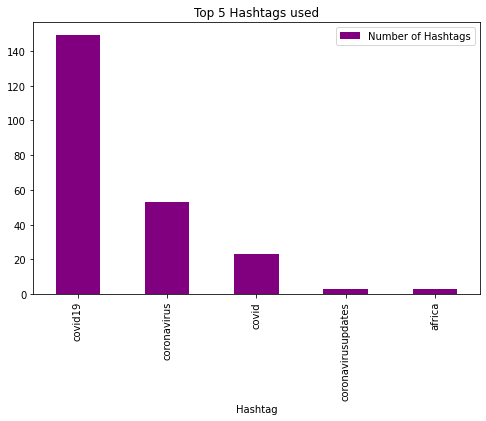

In [17]:
hashes_df.nlargest(5, 'Number of Hashtags').plot(x = 'Hashtag',y='Number of Hashtags', kind='bar', title = "Top 5 Hashtags used", figsize = (8,5), color = 'purple')
plt.show()

### Visualizing number of tweets over time

In [18]:
new_df = df_structured[['time']].copy()

In [19]:
arr = []
for i in new_df['time']:
    arr.append(i)
newarr = [x[:-3] for x in arr]


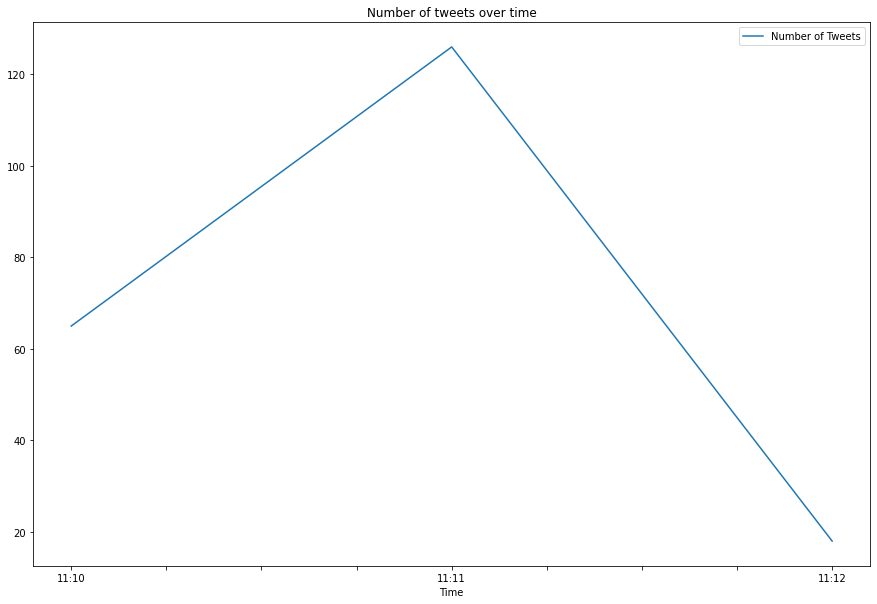

In [20]:
time = Counter(newarr).keys()
num_tweet = Counter(newarr).values()
time_arr=[]
num_tweet_arr = []
for i in time:
    time_arr.append(i)
for j in num_tweet:
    num_tweet_arr.append(j)

time_num_df = pd.DataFrame(
    {'Time': time_arr,
     'Number of Tweets': num_tweet_arr,
    })

ax = plt.gca()

time_num_df.plot(kind='line',x='Time',y='Number of Tweets',ax=ax, figsize = (15,10), title = "Number of tweets over time")

plt.show()

## Types of sources used to access Twitter

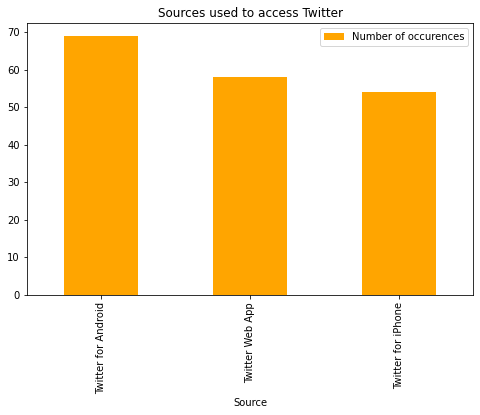

In [21]:
source_dict = {}
for k in df_structured['source']:
    if k not in source_dict:
            source_dict[k] = 1
    else:
        current_val = source_dict[k]
        source_dict[k] = current_val + 1
source_df = pd.DataFrame.from_dict(source_dict, orient='index').reset_index()
source_df.columns = ['Source', 'Number of occurences']
source_df = source_df.nlargest(3, 'Number of occurences')
source_df

source_df.plot(x = 'Source',y='Number of occurences', kind='bar', title = "Sources used to access Twitter", figsize = (8,5), color = 'orange')
plt.show()



## Cleaning tweets 
#### Cleaning tweets in order to effecitvely manipulate tweet data without unnecessary information (URL's, usernames, etc.) 

In [22]:
#an array of words to be ignored by the spell/offensive check
exceptions = ['', 'rt', 'amp']
for i in val:
    exceptions.append(i)

In [23]:
def clean_tweet(index):
    tweet_arr = []
    
    for text in df_structured['tweet'][index].split():
        new_text = ''
        
        #remove punctuation
        for char in text:
            if char not in string.punctuation or char == '@' or char == '#':
                new_text = new_text + char
        
        #remove URL's
        new_text = re.sub(r"http\S+", "", new_text)
        
        #remove Hashtags
        new_text = re.sub(r"#\S+", "", new_text)
        
        #remove Usernames
        new_text = re.sub(r"@\S+", "", new_text)
        
        #remove Elipses
        if new_text.endswith('…'): 
            new_text = new_text[:-(len('…'))] 
        
        #remove Emoji's
        new_text = new_text.encode('ascii', 'ignore').decode('ascii')
        
        #remove exceptions + make lowercase
        if new_text.lower() not in exceptions:
            tweet_arr.append(new_text.lower())
           
        
    #print(tweet_arr)     
    return(tweet_arr)
        
    

## Word Count

#### Find word count of tweets

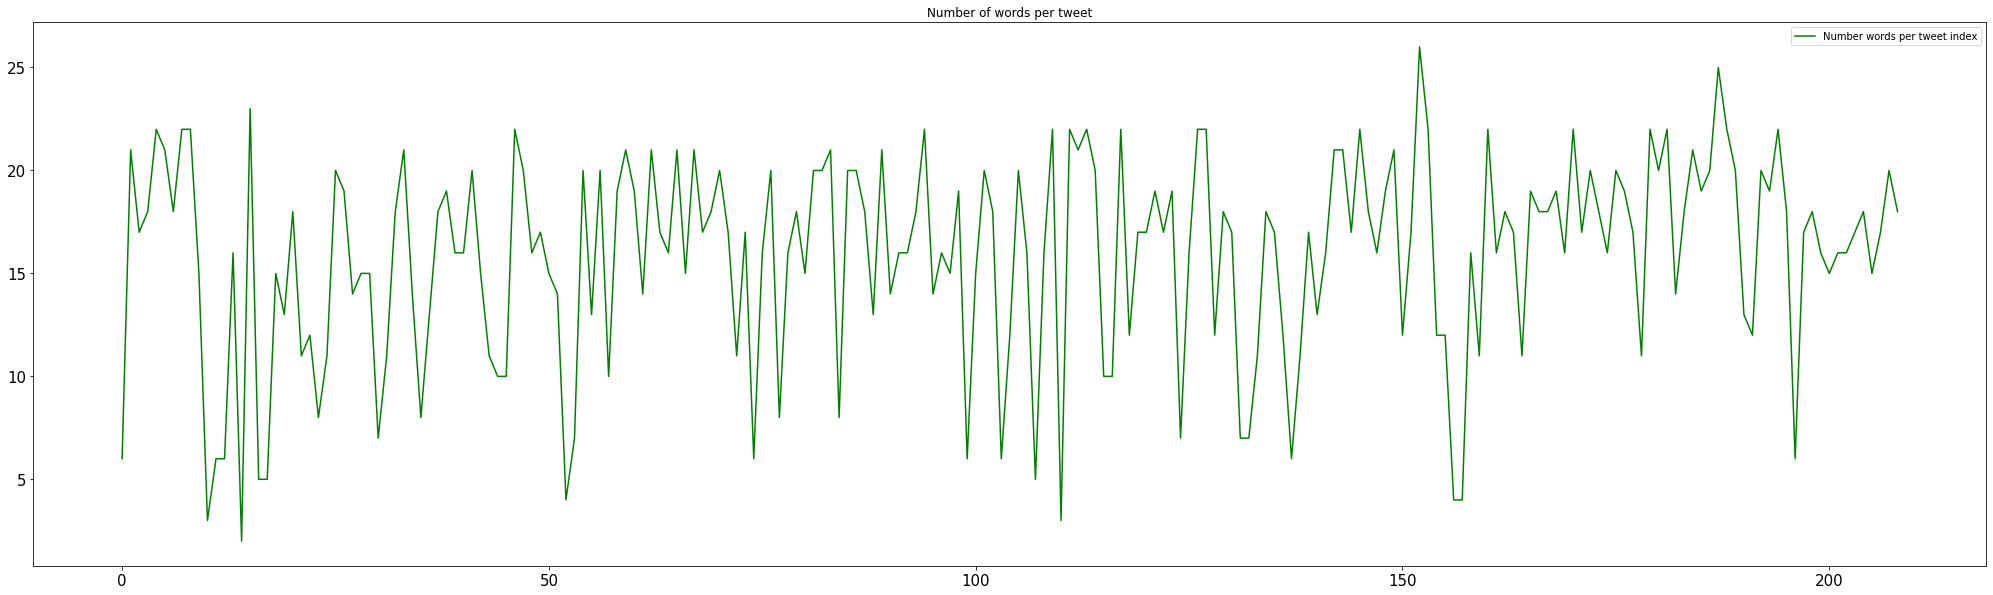

In [24]:
word_count = []
for i in range(len(df_structured['tweet'])):
    cleaned_tweet = clean_tweet(i)
    word_count.append(len(cleaned_tweet))
    
wordCount_df = pd.DataFrame({'Number words per tweet index': word_count,})

lines = wordCount_df.plot.line(figsize=(35,10), title = 'Number of words per tweet', fontsize=15, color = 'green')


In [25]:
print("Average word count per tweet: ", (sum(word_count)/len(word_count)))
print("Min: {} | Max: {}".format(min(word_count),max(word_count))) 

Average word count per tweet:  15.861244019138756
Min: 2 | Max: 26


## Misspelled and Offsensive words
#### Creating a spelling check/word suggestion to use on tweets generated from streaming

## Check mispelled words

#### Spelling checker

In [26]:
def spelling_check(tweet_arr):
    spell = Speller()
    arr = []
    s_arr = []
    count = 0
    cleaned_tweet = clean_tweet(i)
    seperator = ' '
    s = seperator.join(cleaned_tweet)
    s_compare = spell(s)
    if s != s_compare:
        for x in range(len(s.split())):
            if s.split()[x] != s_compare.split()[x]:
                arr.append(s.split()[x])
                count = count + 1
                s_arr.append(s_compare.split()[x])
    return arr,s_arr,count

#### Implement spell check

In [27]:
global c_arr
c_arr = []
c_arr2 = []
for i in range(len(df_structured['tweet'])):
    #print("Tweet: ", df_structured['tweet'][i] )
    cleaned_tweet = clean_tweet(i)
    ret = spelling_check(cleaned_tweet)
    co = ret[0]
    co2 = ret[1]
    c_arr2.append(ret[2])
    if len(co) > 0:
        for j in range(len(co)):
            c_arr.append(co[j])
            print("Word could be misspelled: {} | Suggested word: {} ".format(co[j], co2[j]))

Word could be misspelled: shutdow | Suggested word: shutdown 
Word could be misspelled: marise | Suggested word: arise 
Word could be misspelled: payne | Suggested word: pane 
Word could be misspelled: cdc | Suggested word: dc 
Word could be misspelled: monique | Suggested word: ronique 
Word could be misspelled: shutdow | Suggested word: shutdown 
Word could be misspelled: indias | Suggested word: india 
Word could be misspelled: populati | Suggested word: populate 
Word could be misspelled: indias | Suggested word: india 
Word could be misspelled: indias | Suggested word: india 
Word could be misspelled: feepaying | Suggested word: repaying 
Word could be misspelled: synlab | Suggested word: syllab 
Word could be misspelled: shutdow | Suggested word: shutdown 
Word could be misspelled: marise | Suggested word: arise 
Word could be misspelled: payne | Suggested word: pane 
Word could be misspelled: plannned | Suggested word: planned 
Word could be misspelled: plandemic | Suggested wor

In [28]:
print("Number of misspelled words in dataset: ", len(c_arr))

Number of misspelled words in dataset:  78


### Wordcloud of most commonly identified misspelled words

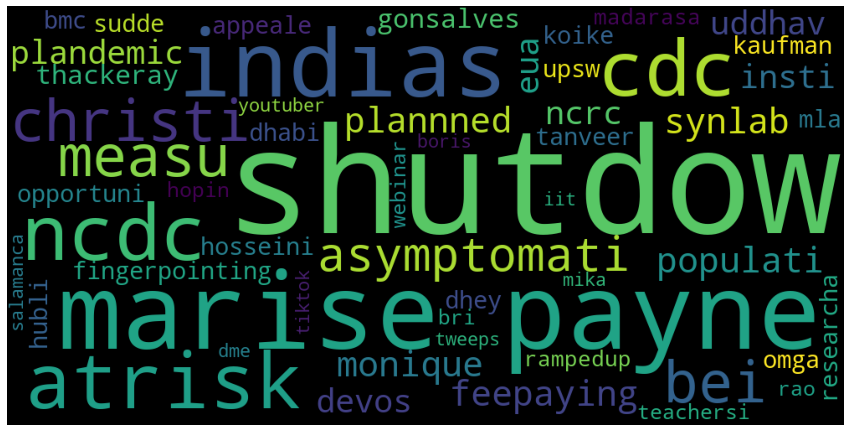

In [29]:
#convert list to string and generate
unique_string=(" ").join(c_arr)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
plt.close()

### Number of misspelled words per tweet index

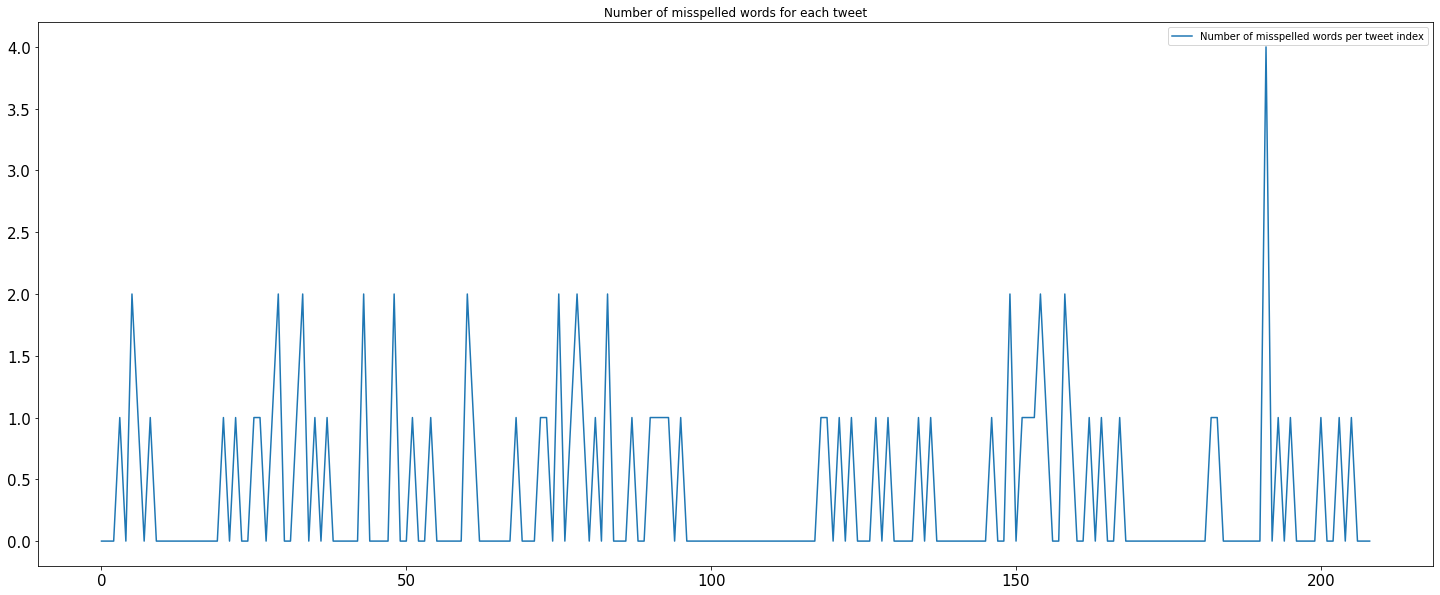

In [30]:
missword_df = pd.DataFrame({

   'Number of misspelled words per tweet index': c_arr2,

   }, )

lines = missword_df.plot.line(figsize=(25,10), title = 'Number of misspelled words for each tweet', fontsize=15)

In [31]:
print("Average misspelled words per tweet: ", (sum(c_arr2)/len(c_arr2)))
print("Min: {} | Max: {}".format(min(c_arr2),max(c_arr2)))

Average misspelled words per tweet:  0.37320574162679426
Min: 0 | Max: 4


## Check offensive tweets

In [32]:
def offensive_check(tweet_arr):
    return predict_prob(tweet_arr)


In [33]:
offsensive_pred_limit = 0.5 # from 0 - 1 with 1 (increasing offensiveness)

In [34]:
count_off = 0
for i in range(len(df_structured['tweet'])):
    cleaned_tweet = clean_tweet(i)
    if len(cleaned_tweet)==0:
        continue
    pred = offensive_check(cleaned_tweet)
    for x in range(len(pred)):
        if  pred[x] > offsensive_pred_limit:
            print("Offensive word identified: [{}] \nFrom tweet: {} \n-----------------------------------".format(cleaned_tweet[x],df_structured['tweet'][i]))
            count_off = count_off + 1
            #print("\nThe following tweet was considered offensive... \nTweet ID: {} | Username: {} | Tweet: '{}'".format(df_structured['tweet_id'][i],df_structured['username'][i],df_structured['tweet'][i]))

Offensive word identified: [fuck] 
From tweet: RT @Harrytheshadow: For fuck sake, England. Why aren't you screaming about this? 👇 #coronavirus #COVID19 https://t.co/ORIwCu41Eq 
-----------------------------------
Offensive word identified: [fuck] 
From tweet: RT @Harrytheshadow: For fuck sake, England. Why aren't you screaming about this? 👇 #coronavirus #COVID19 https://t.co/ORIwCu41Eq 
-----------------------------------


In [35]:
print("Number of offensive words identified in tweets: ", count_off)

Number of offensive words identified in tweets:  2


## Sentiment Analysis

In [36]:
from textblob import TextBlob
positive_tweets = []
negative_tweets = []
for i in range(len(df_structured['tweet'])):
    cleaned_tweet = clean_tweet(i)
    if len(cleaned_tweet)==0:
        continue
    listToStr = ' '.join([str(elem) for elem in cleaned_tweet]) 
    sent = TextBlob(listToStr)
    if sent.sentiment.polarity > 0.5: #increase val to be more strict on positive
        positive_tweets.append(i)
    else:
        negative_tweets.append(i)
print("Number of tweets considered positive: ", len(positive_tweets))
print("Number of tweets considered negative: ", len(negative_tweets))
    

Number of tweets considered positive:  6
Number of tweets considered negative:  203


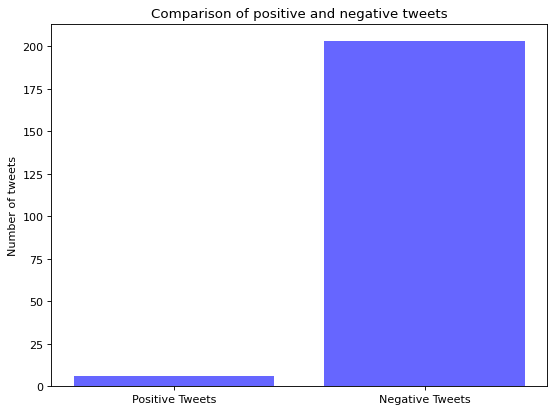

In [37]:
from matplotlib.pyplot import figure

objects = ('Positive Tweets', 'Negative Tweets')
y_pos = np.arange(len(objects))
performance = [len(positive_tweets), len(negative_tweets)]
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.bar(y_pos, performance, align='center', alpha=0.6, color = 'blue')
plt.xticks(y_pos, objects)
plt.ylabel('Number of tweets')
plt.title('Comparison of positive and negative tweets')

plt.show()

### 5 Random tweets categorized as positive

In [38]:
from random import randint
if len(positive_tweets)<5:
    print("Less than 5 tweets were considered positive, these were...\n")
    for i in positive_tweets:
        print(df_structured['tweet'][i])
        print("\n")
else:
    for i in range(5):
        randomNumber = randint(0,len(positive_tweets)-1)
        print(df_structured['tweet'][positive_tweets[randomNumber]])
        print("\n")

RT @Arzz28: When a minister or CM gets affected by #COVID19 why do they get admitted in best private hospitals with best amenities? Don't y…


RT @Arzz28: When a minister or CM gets affected by #COVID19 why do they get admitted in best private hospitals with best amenities? Don't y…


RT @Arzz28: When a minister or CM gets affected by #COVID19 why do they get admitted in best private hospitals with best amenities? Don't y…


RT @Arzz28: When a minister or CM gets affected by #COVID19 why do they get admitted in best private hospitals with best amenities? Don't y…


RT @Arzz28: When a minister or CM gets affected by #COVID19 why do they get admitted in best private hospitals with best amenities? Don't y…




### 5 Random tweets categorized as negative

In [39]:
if len(negative_tweets)<5:
    print("Less than 5 tweets were considered negative, these were...\n")
    for i in negative_tweets:
        print(df_structured['tweet'][i])
        print("\n")
else:
    for i in range(5):
        randomNumber = randint(0,len(negative_tweets)-1)
        print(df_structured['tweet'][negative_tweets[randomNumber]])
        print("\n")

RT @iran_true: Abbas Tabrizian, self-called "father of Islamic medicine":#coronavirus is not transmitted to men through air or personal con…


RT @holmescnn: "I think I'm gonna die, (and) I want to die at home rather than the hospital"  - one desperately ill woman with #COVID19 to…


RT @USAID_NISHTHA: The economic and social impacts of #COVID19 fall harder on women than men. Join in to see @Jhpiego India's program offic…


RT @scotgov: If you have any #coronavirus symptoms, you need to self-isolate and book a test right away.

Use the #TestAndProtect service t…


#HealthMinistry: #India has gradually ramped-up its testing capacity for #COVID19 &amp; conducted over 4.20 lakh tests… https://t.co/5BAUV4tyOr


